In [1]:
from Chemometrics.basic import pload,plot_ConfusionMatrix,build_clf,cal_pct
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV,train_test_split,StratifiedKFold,GroupShuffleSplit,StratifiedShuffleSplit
from sklearn.metrics import f1_score,confusion_matrix,accuracy_score
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif'] = 'SimHei'
plt.style.use('ggplot')

In [2]:
# representative sample, group statified split
data = pload('./地沟油红外数据及标签.p')
ir = data['IR']
desc = data['descriptions']
labels = desc['地沟油含量']
label_ = ~labels.isnull()
rseed = 1
cond1 = desc['备注'].isnull() #不是批发市场的
representatives = cond1
ir_n = ir[~representatives] # not representative
label_n = label_[~representatives] # not representative
ir = ir[representatives]
label = label_[representatives]
desc = desc[~desc.index.duplicated(keep='first')]

# train test split
# stratified group split
train,test= train_test_split(label.index.unique(),test_size=.25,random_state=2)
X_train,X_test = ir[ir.index.isin(train)],ir[ir.index.isin(test)]
y_train,y_test = label[label.index.isin(train)],label[label.index.isin(test)]

In [3]:
#label.value_counts().plot.pie(autopct='%1.1f%%')

不做upsampling

# 预处理

a1 = plt.subplot(2,1,1)
ir.T.diff().diff().plot(ax =a1,legend=False)
a2 = plt.subplot(2,1,2)
ir.T.plot(ax=a2,legend=False)

# gridsearch

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import \
MinMaxScaler,StandardScaler,Normalizer,FunctionTransformer
from sklearn.feature_selection import VarianceThreshold,RFE,SelectKBest
from Chemometrics.spectra_utils import MSC,SNV,first_derivative
from functools import partial

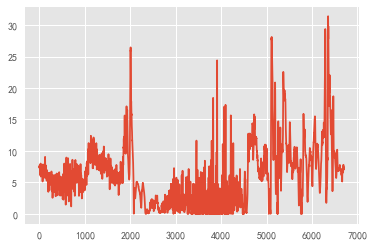

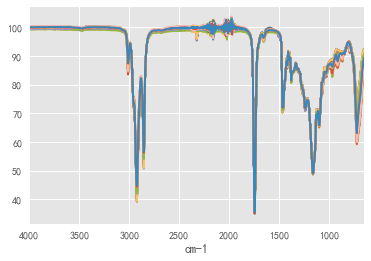

In [34]:
# 特征分析与选择
a = SelectKBest(k='all').fit(ir,label) #anova
a1 = plt.plot(a.scores_)
a2 = ir.T.plot(legend=False)

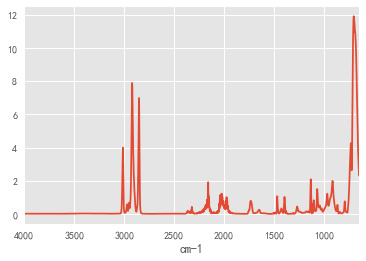

In [38]:
# 特征方差
ir.var().plot()

In [ ]:
# mutual information
from sklearn.feature_selection import mutual_info_classif
mi = mutual_info_classif(ir,label)

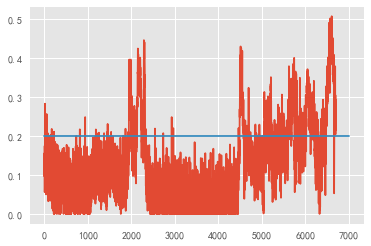

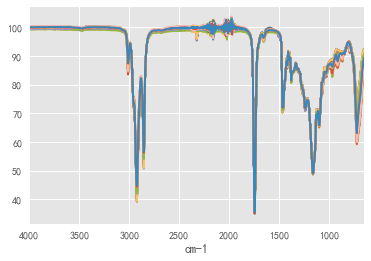

In [60]:
plt.plot(mi)
p80 = np.percentile(mi,80)
plt.plot([0,7000],[p80,p80])
a2 = ir.T.plot(legend=False)

In [6]:
msc = FunctionTransformer(MSC)
snv = FunctionTransformer(SNV)
f1d = FunctionTransformer(first_derivative)
f2d = FunctionTransformer(partial(first_derivative,n=2))
prepr = [None,MinMaxScaler(),StandardScaler(),Normalizer(),msc,snv,f1d,f2d]

In [7]:
def rm_niose(X):
    if isinstance(X,pd.DataFrame):X=X.values
    mk1 = (ir.columns>2400) | (ir.columns<1900) 
    return X[:,mk1]
rmn = FunctionTransformer(rm_niose)

In [8]:
svc = SVC(kernel="linear", C=1)
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
estimators = [('rm_noises',rmn),
              ('preprocessing',FunctionTransformer(first_derivative)),
              ('f_select',SelectKBest()),
       ('clf',SVC())]
pipe = Pipeline(estimators)
param_grid = dict(rm_noises = [None,rmn],
                     preprocessing=prepr,
                     f_select = [None,SelectKBest(k=100)],
                     clf=[SVC(),knn])
grid = GridSearchCV(pipe, param_grid=param_grid)

In [9]:
clf = grid.fit(ir,label)

In [10]:
b = clf.cv_results_['mean_test_score']
c = b.reshape(2,len(prepr),2,2,order='F')

In [61]:
from sklearn.model_selection import cross_val_score
se = SelectKBest(k=100)
f1 = f1d.fit_transform      
s100 = SelectKBest(k=100).fit_transform
mm = MinMaxScaler().fit_transform
o1 = cross_val_score(SVC(),s100(f1(ir),label),label).mean()
o1

0.6842105263157895

In [12]:
from sklearn.model_selection import ParameterGrid

In [13]:
from pandas import MultiIndex
paras = [
     ['None','rmn'], 
    ['None','MinMaxScaler','StandardScaler','Normalizer','msc','snv','f1d','f2d'],
      ['None','SelectKBest'],
     ['SVC','knn'],
                     ]
idx = MultiIndex.from_product(paras[::-1])

In [14]:
p_c = ['rm_noises', 'preprocessing', 'f_select', 'clf']
def get_name(p0):
    names = []
    for i in range(len(p_c)):
        pc = p_c[i]
        j = param_grid[pc].index(p0[pc])
        names.append(paras[i][j])
    return names
ns = []
for p in clf.cv_results_['params']:
    ns.append(get_name(p))

In [15]:
idx = pd.MultiIndex.from_tuples(ns,names=p_c)

In [16]:
idx1 = pd.MultiIndex.from_product(paras[::-1],names=p_c[::-1])
res = pd.Series(b,index=idx1)

In [18]:
results = pd.DataFrame(pd.Series(b,index=idx))

In [63]:
clf.best_params_

{'clf': SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
   max_iter=-1, probability=False, random_state=None, shrinking=True,
   tol=0.001, verbose=False),
 'f_select': SelectKBest(k=100, score_func=<function f_classif at 0x0000023C0425A400>),
 'preprocessing': FunctionTransformer(accept_sparse=False,
           func=<function first_derivative at 0x0000023C0428AE18>,
           inv_kw_args=None, inverse_func=None, kw_args=None,
           pass_y='deprecated', validate=True),
 'rm_noises': None}

In [66]:
results.unstack('preprocessing').to_excel('地沟油gridsearch结果.xlsx')

---